✅ Wczytuję plik: ..\data\01_raw\airline_passenger_satisfaction_sample.csv
Kształt: (500, 24)

Typy danych:


ID                                          int64
Gender                                     object
Age                                         int64
Customer Type                              object
Type of Travel                             object
Class                                      object
Flight Distance                             int64
Departure Delay                             int64
Arrival Delay                             float64
Departure and Arrival Time Convenience      int64
Ease of Online Booking                      int64
Check-in Service                            int64
Online Boarding                             int64
Gate Location                               int64
On-board Service                            int64
Seat Comfort                                int64
Leg Room Service                            int64
Cleanliness                                 int64
Food and Drink                              int64
In-flight Service                           int64



Braki danych (%):


Arrival Delay                             0.002
ID                                        0.000
Age                                       0.000
Gender                                    0.000
Type of Travel                            0.000
Class                                     0.000
Flight Distance                           0.000
Customer Type                             0.000
Departure Delay                           0.000
Departure and Arrival Time Convenience    0.000
Ease of Online Booking                    0.000
Check-in Service                          0.000
Online Boarding                           0.000
Gate Location                             0.000
On-board Service                          0.000
dtype: float64

Liczba cech numerycznych: 19
Liczba cech kategorycznych: 4
Przykładowe kolumny num: ['ID', 'Age', 'Flight Distance', 'Departure Delay', 'Arrival Delay', 'Departure and Arrival Time Convenience', 'Ease of Online Booking', 'Check-in Service']
Przykładowe kolumny kat: ['Gender', 'Customer Type', 'Type of Travel', 'Class']
Balans klas w 'Satisfaction':


Satisfaction
Satisfied                  0.51
Neutral or Dissatisfied    0.49
Name: proportion, dtype: float64

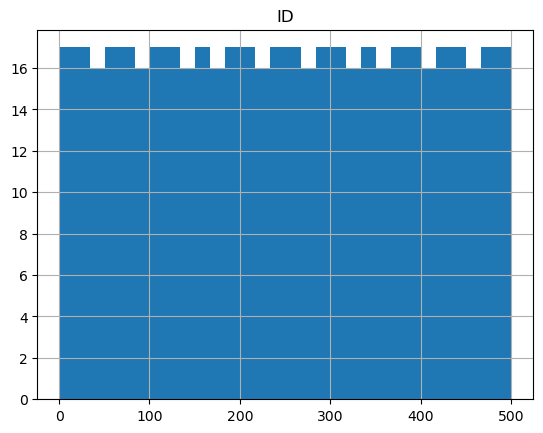

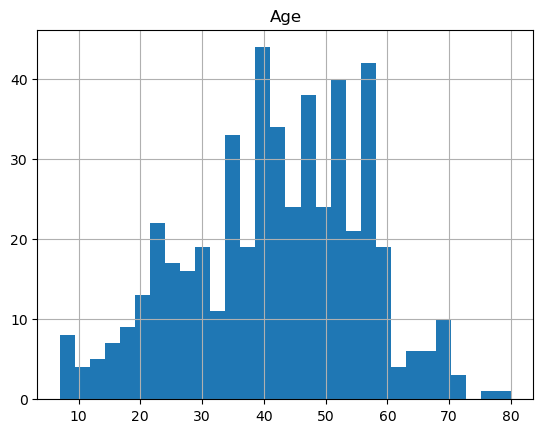

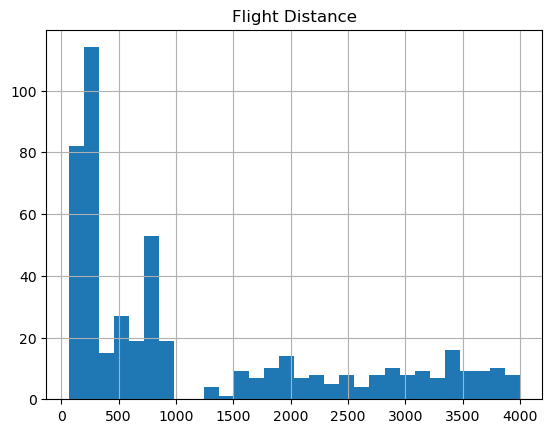

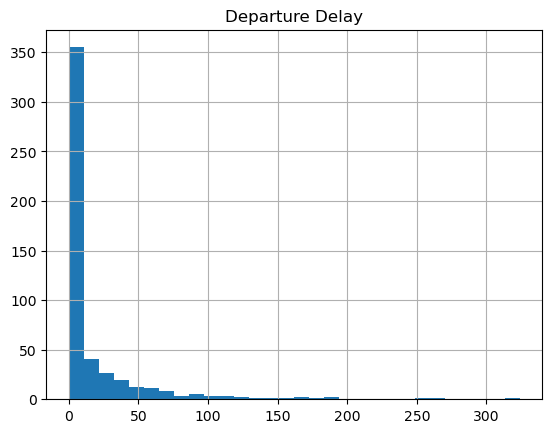

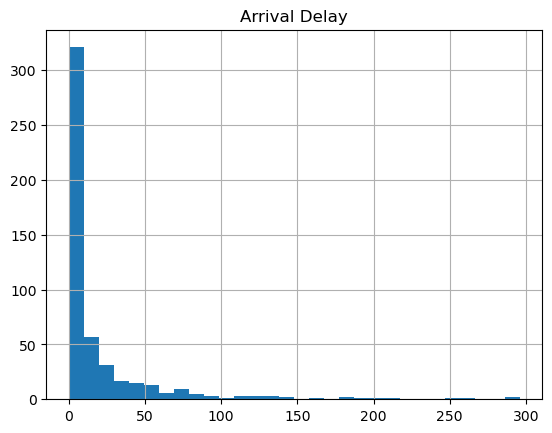

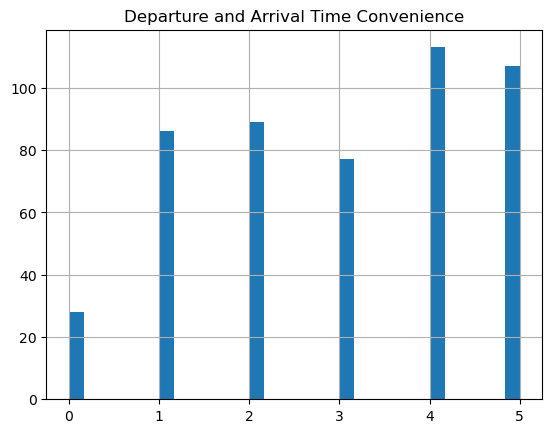

Kolumna: Gender
Gender
Male      251
Female    249
Name: count, dtype: int64
----------------------------------------
Kolumna: Customer Type
Customer Type
Returning     400
First-time    100
Name: count, dtype: int64
----------------------------------------
Kolumna: Type of Travel
Type of Travel
Business    387
Personal    113
Name: count, dtype: int64
----------------------------------------
Kolumna: Class
Class
Business        369
Economy         112
Economy Plus     19
Name: count, dtype: int64
----------------------------------------
Wymiary po transformacji: (400, 28) (100, 28)
Liczba cech łącznie: 28
✅ Zapisano pliki do data/02_interim/


In [7]:
# Szukamy pliku CSV w folderze data/01_raw/
from pathlib import Path

candidates = list(RAW_DIR.glob("*.csv")) + list(RAW_DIR.glob("*.parquet"))
assert candidates, " Brak pliku w data/01_raw/. Wklej tam próbkę danych (200–1000 wierszy)!"
src_path = candidates[0]
print("✅ Wczytuję plik:", src_path)

# Wczytaj dane
if src_path.suffix == ".csv":
    df = pd.read_csv(src_path)
else:
    df = pd.read_parquet(src_path)

# Wyświetl kilka pierwszych wierszy
df.head()

#diagnoza danych
print("Kształt:", df.shape)
print("\nTypy danych:")
display(df.dtypes)

print("\nBraki danych (%):")
display(df.isna().mean().sort_values(ascending=False).head(15))


TARGET = "Satisfaction"  # <— kolumna celu

assert TARGET in df.columns, f"Nie znaleziono kolumny celu: {TARGET}"

y = df[TARGET]
X = df.drop(columns=[TARGET])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Liczba cech numerycznych:", len(num_cols))
print("Liczba cech kategorycznych:", len(cat_cols))
print("Przykładowe kolumny num:", num_cols[:8])
print("Przykładowe kolumny kat:", cat_cols[:8])

# Balans klas w targetcie
print("Balans klas w 'Satisfaction':")
display(y.value_counts(normalize=True).rename("proportion"))

# Rozkłady numeryczne (kilka pierwszych)
for col in num_cols[:6]:
    df[col].hist(bins=30)
    plt.title(col)
    plt.show()

# Top wartości kategorycznych (kilka pierwszych)
for col in cat_cols[:6]:
    print(f"Kolumna: {col}")
    print(df[col].value_counts(dropna=False).head(10))
    print("-"*40)


from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Stratyfikacja (bo klasyfikacja)
stratify = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify
)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

# Kompatybilność z różnymi wersjami sklearn (sparse_output vs sparse)
try:
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

X_train_ready = preprocess.fit_transform(X_train)
X_test_ready  = preprocess.transform(X_test)

print("Wymiary po transformacji:", X_train_ready.shape, X_test_ready.shape)

# Numeryczne = jak było
feat_names = list(num_cols)

# Kategoryczne po OHE
ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
feat_names += cat_feature_names

print("Liczba cech łącznie:", len(feat_names))
pd.Series(feat_names).head()

np.save(INTERIM_DIR/"X_train_ready.npy", X_train_ready)
np.save(INTERIM_DIR/"X_test_ready.npy",  X_test_ready)
y_train.to_csv(INTERIM_DIR/"y_train.csv", index=False)
y_test.to_csv(INTERIM_DIR/"y_test.csv", index=False)
pd.Series(feat_names).to_csv(INTERIM_DIR/"feature_names.csv", index=False)

print("✅ Zapisano pliki do data/02_interim/")


